In [ ]:
from main import read_list_poses, read_list_box

import pickle
import numpy as np
from matplotlib import pyplot as plt
import glob
import os
import itertools
from PIL import Image
from PIL import Image, ImageDraw
from lfd import compute_estimates, dual_quadric_to_ellipsoid_parameters
from plotting import plot_est_and_gt_ellipses_on_images, plot_3D_scene


In [4]:
# Select whether to save output images to files.
save_output_images = True

# Randomly use less images (messo se ci sono video troppo lunghi)
random_downsample = False

# Plot in 3D
plot = True

In [5]:

dataset = 'Aldoma'

# Aldoma
bbs = np.load('Data/{:s}/InputData/bounding_boxes.npy'.format(dataset))  # Bounding boxes [X0, Y0, X1, Y1],
                                                                        # [X0, Y0] = top-left corner
                                                                        # [X1, Y1] = bottom-right corner
                                                                        # [n_frames x n_objects * 4].
K = np.load('Data/{:s}/InputData/intrinsics.npy'.format(dataset))  # Camera intrinsics [3x3].
Ms_t = np.load('Data/{:s}/InputData/camera_poses.npy'.format(dataset))  # Camera pose matrices, transposed and stacked.
                                                                        # [n_frames * 4 x 3].
                                                                        # Each matrix [3x4] transforms points from the
                                                                        # World reference frame to the Camera reference
                                                                        # frame.
visibility = np.load('Data/{:s}/InputData/visibility.npy'.format(dataset))  # Visibility information, indicates whether
                                                                            # a detection is available for a given
                                                                            # object, on a given frame.
                                                                            # [n_frames x n_objects].


In [6]:
bbs.shape

(8, 24)

In [19]:
dataset = 'Tiger2'


PATH = f"Data/{dataset}"
box_list = glob.glob(os.path.join(os.getcwd(), f"{PATH}/bounding_boxes", "*.txt"))
poses_list = glob.glob(os.path.join(os.getcwd(), f"{PATH}/poses_ba", "*.txt"))
intrinsics = f"{PATH}/intrinsics.txt"

t_bbs = read_list_box(box_list)
t_Ms_t = read_list_poses(poses_list)
t_visibility = np.ones((bbs.shape[0], 1))

if random_downsample:
    randomline = np.random.choice(bbs.shape[0], 10)
    t_visibility[randomline, :] = 1

with open(intrinsics) as f:
    intr = f.readlines()
    t_K = np.array([[float(intr[0]), 0, float(intr[2])],
                    [0, float(intr[1]), float(intr[3])],
                    [0, 0, 1]])
    


In [20]:
t_bbs[0]

array([224, 160, 304, 256])

In [21]:
t_bbs.shape

(661, 4)

In [22]:
t_bbs[:,[0, 1]] = t_bbs[:,[1, 0]]
t_bbs[:,[2, 3]] = t_bbs[:,[3, 2]]

In [23]:
t_bbs.shape

(661, 4)

In [24]:
t_bbs[0]

array([160, 224, 256, 304])

In [11]:
t_bbs[0]

array([160, 224, 256, 304])

In [25]:
print(bbs.shape)

print(t_bbs. shape)

(8, 24)
(661, 4)


In [26]:
bbs[0]

array([368.97869873, 241.3981781 , 429.3835144 , 309.05929565,
       441.93484497, 259.12072754, 514.89862061, 325.12350464,
       337.46533203, 309.51794434, 386.55029297, 395.83270264,
       394.25811768, 323.92715454, 480.84927368, 399.02444458,
       326.37182617, 202.48471069, 356.46304321, 264.19009399,
       288.29751587, 249.58882141, 322.54174805, 316.91818237])

In [27]:
im = Image.open('Data/Tiger2/object_detection/0000.jpg')

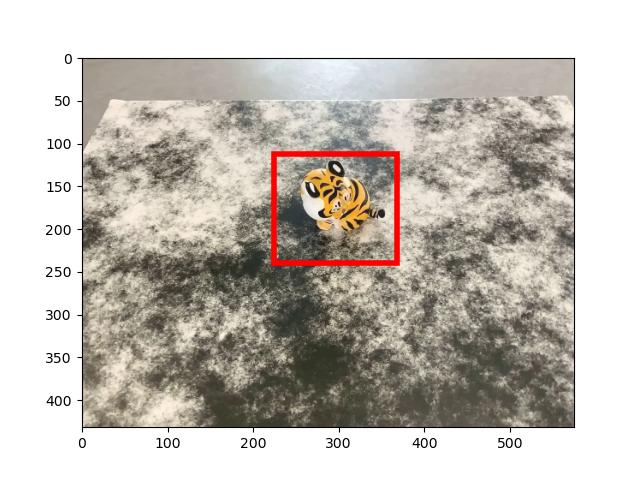

In [28]:
im

In [29]:
img1 = ImageDraw.Draw(im)  

In [30]:
img1.rectangle([(t_bbs[0][1], t_bbs[0][0]), (t_bbs[0][3], t_bbs[0][2])], outline ="red")

In [31]:
im.show()

In [55]:
t_bbs[0]

array([224, 160, 304, 256])

In [24]:
print(K.shape)
print(t_K.shape)


(3, 3)
(3, 3)


In [25]:
print(Ms_t.shape)
print(t_Ms_t.shape)


(32, 3)
(2644, 3)


In [33]:
print(Ms_t[0])
print(t_Ms_t[0])

[ 0.64395   0.463124 -0.608974]
[-0.24369675  0.72306025 -0.64637124]


In [26]:
print(visibility.shape)
print(t_visibility.shape)

(8, 6)
(8, 1)


In [30]:
visibility

array([[ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True]])

In [31]:
t_visibility

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [32]:

dataset = 'Tiger2'
# Compute the number of frames and the number of objects for the current dataset from the size of the visibility matrix.
n_frames = t_visibility.shape[0]
n_objects = t_visibility.shape[1]


######################################
# 2. Run the algorithm: estimate the #
#    object ellipsoids.              #
######################################

[inputCs, estCs, estQs] = compute_estimates(t_bbs, t_K, t_Ms_t, t_visibility)

#############################
# 3. I punti del 3D BB. #
#############################
centre, axes, R = dual_quadric_to_ellipsoid_parameters(estQs[0])

# Possible coordinates
mins = [-ax for (ax) in axes]
maxs = [ax for (ax) in axes]

# Coordinates of the points mins and maxs
points = np.array(list(itertools.product(*zip(mins, maxs))))

# Points in the camera frame
points = np.dot(points, R.T)

# Shift correctly the parralelepiped
points[:, 0:3] = np.add(centre[None, :], points[:, :3],)


# Plot ellipsoids, parralepiped and camera poses in 3D.
if plot:
    fig = plot_3D_scene(estQs, estQs, t_Ms_t, dataset, save_output_images, points)
    plt.show()

IndexError: boolean index did not match indexed array along dimension 0; dimension is 2644 but corresponding boolean dimension is 32